# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.878513,True,10.109976
1,0.263387,False,-0.464678
2,0.235044,True,5.515349
3,1.473901,True,9.448202
4,0.602942,False,0.936806
...,...,...,...
995,0.330615,True,7.163719
996,0.352773,False,1.821211
997,0.648502,True,5.800821
998,1.066638,False,3.639751


<AxesSubplot:xlabel='v0'>

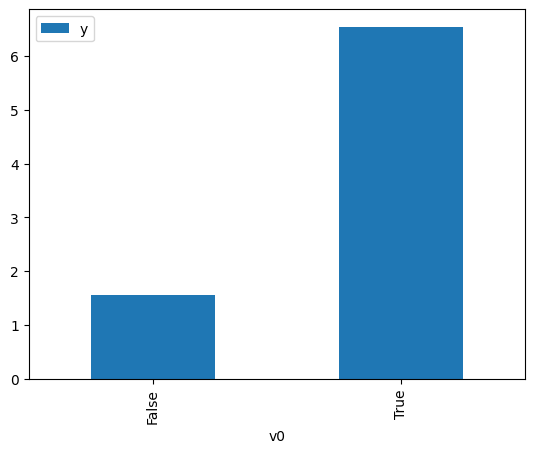

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

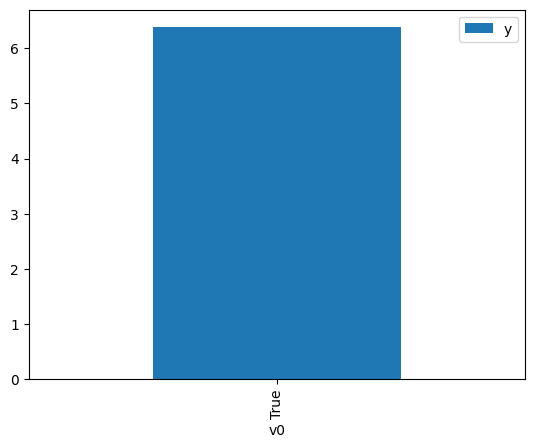

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.199972,False,0.391715,0.436920,2.288750
1,0.116116,False,0.984177,0.454086,2.202224
2,1.173898,False,4.941088,0.257144,3.888865
3,-0.160956,False,0.854189,0.511364,1.955554
4,-1.044437,False,-1.413126,0.685183,1.459465
...,...,...,...,...,...
995,-0.038252,False,-0.039235,0.485945,2.057844
996,2.525902,False,6.177803,0.101433,9.858748
997,0.897783,False,3.074008,0.303218,3.297955
998,2.029909,False,5.413847,0.145502,6.872770


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.369815,True,0.258790,0.259731,3.850138
1,1.739392,True,7.060110,0.821940,1.216634
2,0.354601,True,7.065264,0.594314,1.682611
3,0.478676,True,6.304771,0.618848,1.615905
4,0.386291,True,6.248980,0.600631,1.664916
...,...,...,...,...,...
995,-0.069568,True,3.965936,0.507569,1.970175
996,0.746270,True,5.560673,0.669615,1.493395
997,-0.678974,True,4.466460,0.383481,2.607688
998,-0.021441,True,6.573275,0.517534,1.932239


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.766e+04
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:17:43   Log-Likelihood:                         -1428.4
No. Observations:                1000   AIC:                                      2861.
Df Residuals:                     998   BIC:                                      2871.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2733      0.033     68.160      0.000       2.208       2.339
x2             5.0353      0.050    100.193      0.000       4.937       5.134
==============================================================================
Omnibus:                        1.125   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                1.204
Skew:                           0.062   Prob(JB):                        0.548
Kurtosis:                       2.885   Cond. No.                         2.26
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""